# Lecture 21 - Long Short Term Memory (LSTM)

The recurrent neurons in RNNs have **short-term memory** since they explicitly process the activations from the previous timestep, which inherently depends on the previous timestep's activations, and so on. However, this short-term memory is very short: the data from multiple timesteps back become less and less influential, and this drop-off is very quick. This is not great for problems in natural language processing (NLP) tasks, such as sentiment analysis, since the meaning behind certain words (e.g. pronouns) may depend on other words far away from the original word. This long-distance dependence is not learnable very effectively by RNNs. The problem is even worse for audio analysis or speech recognition because the sequences are far longer since audio data is very dense in time.

**Long** short term memory units (**LSTMs**) are similar to recurrent units in that they process sequence data in a neural architecture with backward connections in order to preserve short-term memory, but they are designed to encode longer-term dependencies than recurrent units. The general idea is that LSTMs work as memory units that can decide if and when to remember older activations in a way that is connected in a differentiable way to the loss function, permitting backpropagation to propagate gradients through the LSTM units. These gradients, if strong enough, will trigger the LSTM units to *save* information.

## Preprocessing

In [1]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import zipfile

In [29]:
# unzip the imdb dataset
with zipfile.ZipFile('../data/imdb.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/imdb/')

In [2]:
# clean the data by removing linebreaks
def prepareData(dir):
    # read the directory of datapoints and labels into a Dataset object
    data = text_dataset_from_directory(dir)
    
    # replace HTML linebreaks from the text with spaces
    return data.map(lambda text, label: (regex_replace(text, '<br />', ' '), label))

# read the directory into memory and clean the text
trainData = prepareData('../data/imdb/train')
testData = prepareData('../data/imdb/test')

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## Experiments With LSTM

These experiments still correspond to the IMDB movie review data, but we use LSTM units rather than simple recurrent units.

In [10]:
# read the directory into memory and clean the text
trainData = prepareData('../data/imdb/train')
testData = prepareData('../data/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [11]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 181,761
Trainable params: 181,761
Non-trainable params: 0
________________________________________________

Epoch 1/10
782/782 [==============================] - 26s 24ms/step - loss: 0.5527 - accuracy: 0.7136 - val_loss: 0.4501 - val_accuracy: 0.7832
Epoch 2/10
782/782 [==============================] - 19s 24ms/step - loss: 0.4517 - accuracy: 0.7939 - val_loss: 0.4653 - val_accuracy: 0.7786
Epoch 3/10
782/782 [==============================] - 19s 24ms/step - loss: 0.4212 - accuracy: 0.8096 - val_loss: 0.4470 - val_accuracy: 0.7852
Epoch 4/10
782/782 [==============================] - 19s 24ms/step - loss: 0.3963 - accuracy: 0.8222 - val_loss: 0.4729 - val_accuracy: 0.7975
Epoch 5/10
782/782 [==============================] - 19s 24ms/step - loss: 0.3717 - accuracy: 0.8372 - val_loss: 0.4823 - val_accuracy: 0.7844
Epoch 6/10
782/782 [==============================] - 19s 24ms/step - loss: 0.3532 - accuracy: 0.8452 - val_loss: 0.5049 - val_accuracy: 0.7896
Epoch 7/10
782/782 [==============================] - 19s 24ms/step - loss: 0.3364 - accuracy: 0.8541 - val_loss: 0.5114 - val_accuracy:

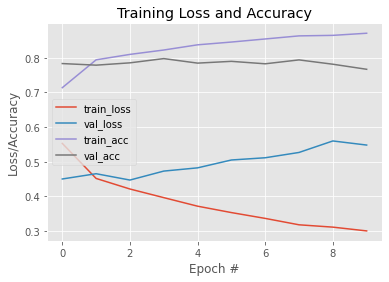

In [12]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [13]:
model.evaluate(testData)

782/782 [==============================] - 8s 10ms/step - loss: 0.5480 - accuracy: 0.7666


[0.5480121374130249, 0.7666400074958801]

Performance improved versus simple recurrent net! But there is some overfitting, so let's try dropout.

In [14]:
# read the directory into memory and clean the text
trainData = prepareData('../data/imdb/train')
testData = prepareData('../data/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# max_tokens most common words (i.e. the vocabulary) are selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [15]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

Epoch 1/10
782/782 [==============================] - 20s 25ms/step - loss: 0.5810 - accuracy: 0.6832 - val_loss: 0.4766 - val_accuracy: 0.7826
Epoch 2/10
782/782 [==============================] - 19s 25ms/step - loss: 0.4561 - accuracy: 0.7928 - val_loss: 0.4537 - val_accuracy: 0.7847
Epoch 3/10
782/782 [==============================] - 19s 25ms/step - loss: 0.4276 - accuracy: 0.8090 - val_loss: 0.4535 - val_accuracy: 0.7796
Epoch 4/10
782/782 [==============================] - 19s 25ms/step - loss: 0.4026 - accuracy: 0.8218 - val_loss: 0.4564 - val_accuracy: 0.7842
Epoch 5/10
782/782 [==============================] - 19s 25ms/step - loss: 0.3777 - accuracy: 0.8361 - val_loss: 0.4706 - val_accuracy: 0.7837
Epoch 6/10
782/782 [==============================] - 19s 25ms/step - loss: 0.3618 - accuracy: 0.8443 - val_loss: 0.5199 - val_accuracy: 0.7743
Epoch 7/10
782/782 [==============================] - 19s 25ms/step - loss: 0.3450 - accuracy: 0.8540 - val_loss: 0.4981 - val_accuracy:

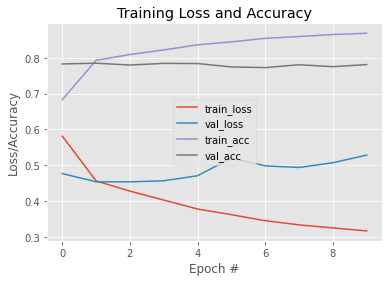

In [16]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [17]:
model.evaluate(testData)

782/782 [==============================] - 8s 10ms/step - loss: 0.5281 - accuracy: 0.7808


[0.5281499624252319, 0.7808399796485901]

In [18]:
# read the directory into memory and clean the text
trainData = prepareData('../data/imdb/train')
testData = prepareData('../data/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# the vocabulary is selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64, return_sequences = True))

# add a fully-connected recurrent layer
model.add(LSTM(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [19]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_4 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

Epoch 1/10
782/782 [==============================] - 26s 32ms/step - loss: 0.5914 - accuracy: 0.6781 - val_loss: 0.4765 - val_accuracy: 0.7781
Epoch 2/10
782/782 [==============================] - 25s 31ms/step - loss: 0.4586 - accuracy: 0.7927 - val_loss: 0.4388 - val_accuracy: 0.7912
Epoch 3/10
782/782 [==============================] - 25s 31ms/step - loss: 0.4279 - accuracy: 0.8097 - val_loss: 0.4319 - val_accuracy: 0.7999
Epoch 4/10
782/782 [==============================] - 25s 31ms/step - loss: 0.4024 - accuracy: 0.8209 - val_loss: 0.4280 - val_accuracy: 0.8014
Epoch 5/10
782/782 [==============================] - 25s 31ms/step - loss: 0.3813 - accuracy: 0.8294 - val_loss: 0.4364 - val_accuracy: 0.7933
Epoch 6/10
782/782 [==============================] - 25s 31ms/step - loss: 0.3603 - accuracy: 0.8443 - val_loss: 0.4571 - val_accuracy: 0.7996
Epoch 7/10
782/782 [==============================] - 25s 31ms/step - loss: 0.3394 - accuracy: 0.8562 - val_loss: 0.4425 - val_accuracy:

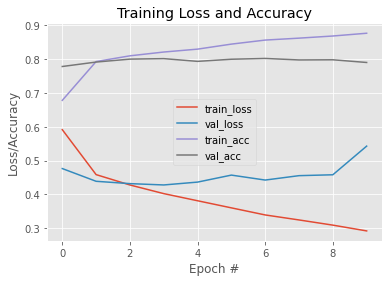

In [20]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [21]:
model.evaluate(testData)

782/782 [==============================] - 10s 13ms/step - loss: 0.5428 - accuracy: 0.7900


[0.5427930355072021, 0.7900000214576721]

Let's try a **bidirectional** LSTM layer.

In [22]:
# read the directory into memory and clean the text
trainData = prepareData('../data/imdb/train')
testData = prepareData('../data/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# the vocabulary is selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.5))

# add a fully-connected recurrent layer
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [23]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_5 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

Epoch 1/10
782/782 [==============================] - 31s 37ms/step - loss: 0.5311 - accuracy: 0.7246 - val_loss: 0.4645 - val_accuracy: 0.7823
Epoch 2/10
782/782 [==============================] - 29s 37ms/step - loss: 0.4403 - accuracy: 0.8007 - val_loss: 0.4255 - val_accuracy: 0.8007
Epoch 3/10
782/782 [==============================] - 29s 37ms/step - loss: 0.4125 - accuracy: 0.8162 - val_loss: 0.4367 - val_accuracy: 0.8034
Epoch 4/10
782/782 [==============================] - 29s 37ms/step - loss: 0.3902 - accuracy: 0.8280 - val_loss: 0.4344 - val_accuracy: 0.7950
Epoch 5/10
782/782 [==============================] - 29s 37ms/step - loss: 0.3685 - accuracy: 0.8404 - val_loss: 0.4737 - val_accuracy: 0.7899
Epoch 6/10
782/782 [==============================] - 29s 37ms/step - loss: 0.3518 - accuracy: 0.8497 - val_loss: 0.5137 - val_accuracy: 0.7852
Epoch 7/10
782/782 [==============================] - 29s 37ms/step - loss: 0.3330 - accuracy: 0.8591 - val_loss: 0.5006 - val_accuracy:

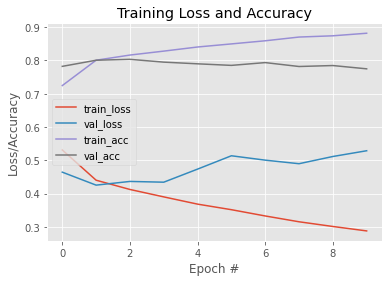

In [24]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [25]:
model.evaluate(testData)

782/782 [==============================] - 11s 14ms/step - loss: 0.5288 - accuracy: 0.7748


[0.5288146734237671, 0.7748399972915649]

In [31]:
# read the directory into memory and clean the text
trainData = prepareData('../data/imdb/train')
testData = prepareData('../data/imdb/test')

# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 1000
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

# adapt() fits the TextVectorization layer to our text dataset. This is when the
# the vocabulary is selected.
trainText = trainData.map(lambda text, label: text)

vectorizeLayer.adapt(trainText)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences = True)))

# add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(64)))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(1, activation = 'sigmoid'))

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [32]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_7 (TextVe (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 128)          128128    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

Epoch 1/10
782/782 [==============================] - 38s 45ms/step - loss: 0.5139 - accuracy: 0.7379 - val_loss: 0.4384 - val_accuracy: 0.7917
Epoch 2/10
782/782 [==============================] - 33s 42ms/step - loss: 0.4280 - accuracy: 0.8044 - val_loss: 0.4305 - val_accuracy: 0.7970
Epoch 3/10
782/782 [==============================] - 33s 42ms/step - loss: 0.4037 - accuracy: 0.8178 - val_loss: 0.4458 - val_accuracy: 0.7835
Epoch 4/10
782/782 [==============================] - 33s 42ms/step - loss: 0.3759 - accuracy: 0.8324 - val_loss: 0.4479 - val_accuracy: 0.7942
Epoch 5/10
782/782 [==============================] - 33s 42ms/step - loss: 0.3479 - accuracy: 0.8454 - val_loss: 0.4784 - val_accuracy: 0.7955
Epoch 6/10
782/782 [==============================] - 33s 42ms/step - loss: 0.3224 - accuracy: 0.8590 - val_loss: 0.5075 - val_accuracy: 0.7824
Epoch 7/10
782/782 [==============================] - 33s 42ms/step - loss: 0.3024 - accuracy: 0.8710 - val_loss: 0.5209 - val_accuracy:

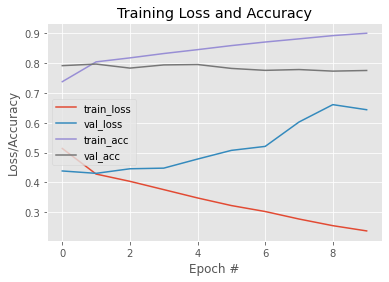

In [33]:
epochs = 10

H = model.fit(trainData, validation_data = testData, epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [34]:
model.evaluate(testData)

782/782 [==============================] - 13s 16ms/step - loss: 0.6439 - accuracy: 0.7755


[0.6438706517219543, 0.7754799723625183]

In [35]:
print(model.predict(['Watching this film was the worst experience of my life and I would rather die than watch it again.']))

print(model.predict(['The acting is only okay in this movie, but it has an amazing storyline, so I rate it as good but not great.']))

print(model.predict(['Dodgeball is my brother\'s favorite movie, but I hate it']))

print(model.predict(['Dodgeball is my brother\'s favorite movie and it has its moments, but I think the comedy is sophomoric and crude. The acting is great, but the writing is subpar. Overall, I would rate this movie 2/10.']))

print(model.predict(['I love Nicholas Cage, but this movie is horrible. NOT THE BEES.']))

[[0.00387486]]
[[0.9667904]]
[[0.99967563]]
[[0.9999263]]
[[0.00513835]]


In [27]:
# delete the unzipped imdb dataset (this is just so I can upload to GitHub)
if os.path.isfile('../data/imdb/README'):
    shutil.rmtree('../data/imdb')